<h1>Sam Armstrong Assignment 4 CS545</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
import pandas

import torch
import mlutilities as ml  # for ml.draw
import optimizers as opt  # for opt.sgd, opt.adam, and opt.scg

import time
import copy
import pickle, gzip

import neuralnetworks as nn
# import optimizers as opt  # from Lecture Notes

In [2]:
class NeuralNetwork_Convolutional():
    
    def __init__(self, n_channels_in_image, image_size,
                 n_units_in_conv_layers, kernels_size_and_stride,
                 n_units_in_fc_hidden_layers,
                 classes, use_gpu=False, verbose=True):

        if not isinstance(n_units_in_conv_layers, list):
            raise Exception('n_units_in_conv_layers must be a list')

        if not isinstance(n_units_in_fc_hidden_layers, list):
            raise Exception('n_units_in_fc_hidden_layers must be a list')
        
        if use_gpu and not torch.cuda.is_available():
            print('\nGPU is not available. Running on CPU.\n')
            use_gpu = False

        self.n_channels_in_image = n_channels_in_image
        self.image_size = image_size 
        self.n_units_in_conv_layers = n_units_in_conv_layers
        self.n_units_in_fc_hidden_layers = n_units_in_fc_hidden_layers
        self.kernels_size_and_stride = kernels_size_and_stride
        self.n_outputs = len(classes)
        self.classes = np.array(classes)
        self.use_gpu = use_gpu
        self.verbose = verbose
        
        self.n_conv_layers = len(self.n_units_in_conv_layers)
        self.n_fc_hidden_layers = len(self.n_units_in_fc_hidden_layers)

        # Build the net layers
        self.nnet = torch.nn.Sequential()

        # Add convolutional layers

        n_units_previous = self.n_channels_in_image
        output_size_previous = self.image_size
        n_layers = 0
        if self.n_conv_layers > 0:

            for (n_units, kernel) in zip(self.n_units_in_conv_layers, self.kernels_size_and_stride):
                n_units_previous, output_size_previous = self._add_conv2d_tanh(n_layers,
                                        n_units_previous, output_size_previous, n_units, kernel)
                n_layers += 1 # for text label in layer
                
        # A4.3 version moved following statement left one indent level
        
        self.nnet.add_module('flatten', torch.nn.Flatten())  # prepare for fc layers

        n_inputs = output_size_previous ** 2 * n_units_previous
        if self.n_fc_hidden_layers > 0:
            for n_units in self.n_units_in_fc_hidden_layers:
                n_inputs = self._add_fc_tanh(n_layers, n_inputs, n_units)
                n_layers += 1

        self.nnet.add_module(f'output_{n_layers}', torch.nn.Linear(n_inputs, self.n_outputs))

        # Member variables for standardization
        self.Xmeans = None
        self.Xstds = None

        if self.use_gpu:
            self.nnet.cuda()

        self.n_epochs = 0
        self.error_trace = []

    def _add_conv2d_tanh(self, n_layers, n_units_previous, output_size_previous,
                   n_units, kernel_size_and_stride):
        kernel_size, kernel_stride = kernel_size_and_stride
        self.nnet.add_module(f'conv_{n_layers}', torch.nn.Conv2d(n_units_previous, n_units,
                                                                 kernel_size, kernel_stride))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        output_size_previous = (output_size_previous - kernel_size) // kernel_stride + 1
        n_units_previous = n_units                
        return n_units_previous, output_size_previous
    
    def _add_fc_tanh(self, n_layers, n_inputs, n_units):
        self.nnet.add_module(f'linear_{n_layers}', torch.nn.Linear(n_inputs, n_units))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        n_inputs = n_units
        return n_inputs

    def __repr__(self):
        str = f'''{type(self).__name__}(
                            n_channels_in_image={self.n_channels_in_image},
                            image_size={self.image_size},
                            n_units_in_conv_layers={self.n_units_in_conv_layers},
                            kernels_size_and_stride={self.kernels_size_and_stride},
                            n_units_in_fc_hidden_layers={self.n_units_in_fc_hidden_layers},
                            classes={self.classes},
                            use_gpu={self.use_gpu})'''

        str += self.nnet
        if self.n_epochs > 0:
            str += f'\n   Network was trained for {self.n_epochs} epochs that took {self.training_time:.4f} seconds.'
            str += f'\n   Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str
        
    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

    def train(self, X, T, n_epochs, learning_rate=0.01):

        start_time = time.time()
        
        self.learning_rate = learning_rate

        if T.ndim == 1:
            T = T.reshape((-1, 1))

        _, T = np.where(T == self.classes)  # convert to labels from 0

        self._setup_standardize(X, T)
        X = self._standardizeX(X)

        X = torch.tensor(X)
        T = torch.tensor(T.reshape(-1))
        if self.use_gpu:
            X = X.cuda()
            T = T.cuda()

            
        self.optimizer = torch.optim.Adam(self.nnet.parameters(), lr=learning_rate)
        self.loss_F = torch.nn.CrossEntropyLoss()

        for epoch in range(1, n_epochs + 1):

            self.optimizer.zero_grad()

            Y = self.nnet(X)

            error = self.loss_F(Y, T)
            
            if epoch % int(n_epochs/10) == 0 and self.verbose:
                print(f'Epoch {epoch} error {error:.5f}')

            error.backward()

            self.optimizer.step()
            
            self.error_trace.append(error)
        
        self.training_time = time.time() - start_time
        
    def get_error_trace(self):
        return self.error_trace
    
    def _softmax(self, Y):
        mx = Y.max()
        expY = np.exp(Y - mx)
        denom = expY.sum(axis=1).reshape((-1, 1)) + sys.float_info.epsilon
        return expY / denom
    
    def use(self, X):
        self.nnet.eval()  # turn off gradients and other aspects of training
        X = self._standardizeX(X)
        X = torch.tensor(X)
        if self.use_gpu:
            X = X.cuda()

        Y = self.nnet(X)

        if self.use_gpu:
            Y = Y.cpu()
        Y = Y.detach().numpy()
        Yclasses = self.classes[Y.argmax(axis=1)].reshape((-1, 1))

        return Yclasses, self._softmax(Y)


<h2>Simple Example with Squares and Diamonds</h2>

Repeating the example from lecture notes.

In [3]:
def make_images(nEach):
    images = np.zeros((nEach * 2, 1, 20, 20))  # nSamples, nChannels, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(nEach * 2, 1))
    centers = np.zeros((nEach * 2, 2))
    for i in range(nEach * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < nEach:
            # squares
            images[i, 0, x - r:x + r, y + r] = 1.0
            images[i, 0, x - r:x + r, y - r] = 1.0
            images[i, 0, x - r, y - r:y + r] = 1.0
            images[i, 0, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, 0, range(x - r, x), range(y, y + r)] = 1.0
            images[i, 0, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, 0, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, 0, range(x, x + r), range(y - r, y)] = 1.0
            # images += np.random.randn(*images.shape) * 0.5
            T = np.ones((nEach * 2, 1))
            T[nEach:] = 2
    return images.astype(np.float32), T.astype(np.int)

Xtrain, Ttrain = make_images(500)
Xtest, Ttest = make_images(10)

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 1, 20, 20), (1000, 1), (20, 1, 20, 20), (20, 1))

In [4]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[5], # , 5],
                                   n_units_in_fc_hidden_layers=[2], # 10, 10],
                                   classes=[1, 2],
                                   kernels_size_and_stride=[[5, 2]], # , [4, 1]],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 50, learning_rate=0.01)

Epoch 5 error 0.52405
Epoch 10 error 0.36662
Epoch 15 error 0.24395
Epoch 20 error 0.16086
Epoch 25 error 0.11042
Epoch 30 error 0.08320
Epoch 35 error 0.06659
Epoch 40 error 0.05520
Epoch 45 error 0.04691
Epoch 50 error 0.04066


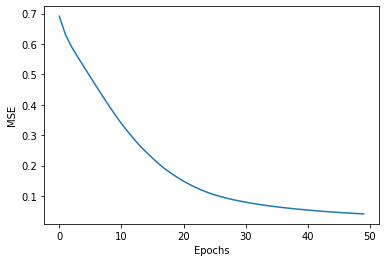

In [5]:
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

In [6]:
Yclasses, Y = nnet.use(Xtest)

print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.', end='')
print(f'  Training took {nnet.training_time:.3f} seconds.')

20 out of 20 test samples correctly classified.  Training took 1.216 seconds.


In [7]:
def show_layer_output(nnet, X_sample, layer):
    outputs = []
    reg = nnet.nnet[layer * 2].register_forward_hook(
        lambda self, i, o: outputs.append(o))
    nnet.use(X_sample)
    reg.remove()
    output = outputs[0]

    n_units = output.shape[1]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit+1)
        plt.imshow(output[0, unit, :, :].detach(),cmap='binary')
        plt.axis('off')
    return output

def show_layer_weights(nnet, layer):
    W = nnet.nnet[layer*2].weight.detach()
    n_units = W.shape[0]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit + 1)
        plt.imshow(W[unit, 0, :, :], cmap='binary')
        plt.axis('off')
    return W

(-0.5, 19.5, 19.5, -0.5)

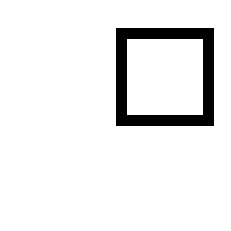

In [8]:
X_sample = Xtest[0:1, :, :, :]
plt.imshow(X_sample[0, 0, :, :], cmap='binary')
plt.axis('off')

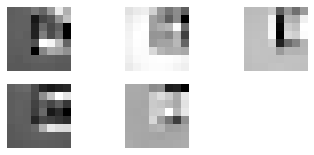

In [9]:
show_layer_output(nnet, X_sample, 0);

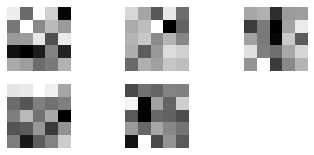

In [10]:
show_layer_weights(nnet, 0);

<h2>MNIST Digits</h2>

Investigate the application of your code to the classification of MNIST digits, which you may download from this site. http://deeplearning.net/tutorial/gettingstarted.html

In [11]:
# !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

In [12]:
Xtrain = train_set[0]
Ttrain = train_set[1]
Xtrain.shape, Ttrain.shape

((50000, 784), (50000,))

In [13]:
a = Xtrain[0, :].reshape(28, 28)
a.shape

(28, 28)

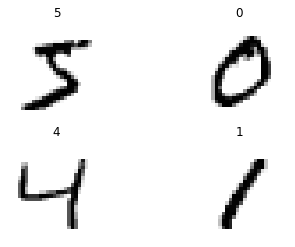

In [14]:
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(Xtrain[i, :].reshape(28, 28), cmap='binary')
    plt.title(Ttrain[i])
    plt.axis('off');

## CNN Classifier

In [15]:
Xtrain = train_set[0].reshape(50000, 1, 28, 28)
Ttrain = train_set[1].reshape(50000, 1)
Xvalid = valid_set[0].reshape(10000, 1, 28, 28)
Tvalid = valid_set[1].reshape(10000, 1)
Xtest = test_set[0].reshape(10000, 1, 28, 28)
Ttest = test_set[1].reshape(10000, 1)
Xtrain.shape, Ttrain.shape, Xvalid.shape, Tvalid.shape, Xtest.shape, Ttest.shape

((50000, 1, 28, 28),
 (50000, 1),
 (10000, 1, 28, 28),
 (10000, 1),
 (10000, 1, 28, 28),
 (10000, 1))

In [16]:
def testModel(conv_layers, hidden_layers, kernels_size_and_stride, epochs, learning_rate=0.1, use_gpu=True):
    nnet1 = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=conv_layers,
                                   n_units_in_fc_hidden_layers=hidden_layers, 
                                   classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                   kernels_size_and_stride=kernels_size_and_stride,
                                   use_gpu=use_gpu)
    nnet1.train(Xtrain, Ttrain, epochs, learning_rate=learning_rate)
    YclassesTrain, Ytrain = nnet1.use(Xtrain)
    YclassesValid, Yvalid = nnet1.use(Xvalid)
    YclassesTest, Ytest = nnet1.use(Xtest)
    print(f'{np.sum(Ttrain == YclassesTrain)/Ttrain.shape[0]*100:.2f}% or {np.sum(Ttrain == YclassesTrain)} out of {Ttrain.shape[0]} training samples correctly classified.')
    print(f'{np.sum(Tvalid == YclassesValid)/Tvalid.shape[0]*100:.2f}% or {np.sum(Tvalid == YclassesValid)} out of {Tvalid.shape[0]} validation samples correctly classified.')
    print(f'{np.sum(Ttest == YclassesTest)/Ttest.shape[0]*100:.2f}% or {np.sum(Ttest == YclassesTest)} out of {Ttest.shape[0]} testing samples correctly classified.')

<h3>Model 1 conv_layers=[10], fc_hidden_layers=[10], kernels_size_and_stride=[[5, 5]], epochs = 100</h3>

In [21]:
testModel([10], [10], [[5, 5]], 100)


GPU is not available. Running on CPU.

Epoch 10 error 0.61152
Epoch 20 error 0.46129
Epoch 30 error 0.38732
Epoch 40 error 0.33704
Epoch 50 error 0.30652
Epoch 60 error 0.27948
Epoch 70 error 0.26672
Epoch 80 error 0.24467
Epoch 90 error 0.23163
Epoch 100 error 0.23009
93.49% or 46746 out of 50000 training samples correctly classified.
92.72% or 9272 out of 10000 validation samples correctly classified.
91.77% or 9177 out of 10000 testing samples correctly classified.


<h3>Model 2 conv_layers=[10], fc_hidden_layers=[10], kernels_size_and_stride=[[5, 3]], epochs = 100</h3>

In [19]:
testModel([10], [10], [[5, 3]], 100)


GPU is not available. Running on CPU.

Epoch 10 error 0.76459
Epoch 20 error 0.56048
Epoch 30 error 0.45822
Epoch 40 error 0.39175
Epoch 50 error 0.34950
Epoch 60 error 0.31874
Epoch 70 error 0.29615
Epoch 80 error 0.27928
Epoch 90 error 0.26348
Epoch 100 error 0.25301
92.79% or 46394 out of 50000 training samples correctly classified.
92.02% or 9202 out of 10000 validation samples correctly classified.
91.55% or 9155 out of 10000 testing samples correctly classified.


<h3>Model 3 conv_layers=[10], fc_hidden_layers=[20], kernels_size_and_stride=[[5, 3]], epochs = 100</h3>

In [20]:
testModel([10], [20], [[5, 3]], 100)


GPU is not available. Running on CPU.

Epoch 10 error 0.54104
Epoch 20 error 0.37822
Epoch 30 error 0.29806
Epoch 40 error 0.25040
Epoch 50 error 0.22347
Epoch 60 error 0.20252
Epoch 70 error 0.18604
Epoch 80 error 0.17434
Epoch 90 error 0.16121
Epoch 100 error 0.15606
95.82% or 47912 out of 50000 training samples correctly classified.
94.07% or 9407 out of 10000 validation samples correctly classified.
93.32% or 9332 out of 10000 testing samples correctly classified.


<h3>Model 4 conv_layers=[10, 10], fc_hidden_layers=[20], kernels_size_and_stride=[[5, 3], [4, 2]], epochs = 200</h3>

In [21]:
testModel([10, 10], [20], [[5, 3], [4, 2]], 200)


GPU is not available. Running on CPU.

Epoch 20 error 0.38405
Epoch 40 error 0.23864
Epoch 60 error 0.18163
Epoch 80 error 0.15155
Epoch 100 error 0.13665
Epoch 120 error 0.13015
Epoch 140 error 0.11798
Epoch 160 error 0.10055
Epoch 180 error 0.09713
Epoch 200 error 0.10670
96.62% or 48309 out of 50000 training samples correctly classified.
94.07% or 9407 out of 10000 validation samples correctly classified.
93.87% or 9387 out of 10000 testing samples correctly classified.


<h3>Model 5 conv_layers=[10, 20], fc_hidden_layers=[20], kernels_size_and_stride=[[5, 3], [4, 2]], epochs = 200</h3>

In [22]:
testModel([10, 20], [20], [[5, 3], [4, 2]], 200)


GPU is not available. Running on CPU.

Epoch 20 error 0.33973
Epoch 40 error 0.21018
Epoch 60 error 0.15715
Epoch 80 error 0.13116
Epoch 100 error 0.12564
Epoch 120 error 0.09730
Epoch 140 error 0.08414
Epoch 160 error 0.09531
Epoch 180 error 0.07120
Epoch 200 error 0.07905
97.68% or 48840 out of 50000 training samples correctly classified.
93.92% or 9392 out of 10000 validation samples correctly classified.
93.76% or 9376 out of 10000 testing samples correctly classified.


<h3>Model 6 conv_layers=[10, 20, 30], fc_hidden_layers=[20], kernels_size_and_stride=[[5, 3], [4, 2], [3, 1]], epochs = 200</h3>

In [23]:
testModel([10, 20, 30], [20], [[5, 3], [4, 2], [3, 1]], 200)


GPU is not available. Running on CPU.

Epoch 20 error 0.49307
Epoch 40 error 0.26076
Epoch 60 error 0.17106
Epoch 80 error 0.12782
Epoch 100 error 0.10416
Epoch 120 error 0.08806
Epoch 140 error 0.08228
Epoch 160 error 0.06727
Epoch 180 error 0.09260
Epoch 200 error 0.05774
98.63% or 49313 out of 50000 training samples correctly classified.
94.06% or 9406 out of 10000 validation samples correctly classified.
93.52% or 9352 out of 10000 testing samples correctly classified.


<h3>Model 7 conv_layers=[10, 20, 30, 40], fc_hidden_layers=[20], kernels_size_and_stride=[[5, 3], [4, 2], [3, 1], [1, 1]], epochs = 200</h3>

In [24]:
testModel([10, 20, 30, 40], [20], [[5, 3], [4, 2], [3, 1], [1, 1]], 200)


GPU is not available. Running on CPU.

Epoch 20 error 0.39970
Epoch 40 error 0.20011
Epoch 60 error 0.13291
Epoch 80 error 0.10043
Epoch 100 error 0.09438
Epoch 120 error 0.06277
Epoch 140 error 0.04507
Epoch 160 error 0.03623
Epoch 180 error 0.10348
Epoch 200 error 0.04930
98.78% or 49391 out of 50000 training samples correctly classified.
95.02% or 9502 out of 10000 validation samples correctly classified.
94.82% or 9482 out of 10000 testing samples correctly classified.


<h3>Model 8 conv_layers=[10, 20, 30, 40], fc_hidden_layers=[20], kernels_size_and_stride=[[5, 3], [4, 2], [3, 1], [1, 2]], epochs = 300</h3>

In [25]:
testModel([10, 20, 30, 40], [20], [[5, 3], [4, 2], [3, 1], [1, 2]], 200)


GPU is not available. Running on CPU.

Epoch 20 error 0.43636
Epoch 40 error 0.22165
Epoch 60 error 0.14856
Epoch 80 error 0.11110
Epoch 100 error 0.11395
Epoch 120 error 0.07644
Epoch 140 error 0.05833
Epoch 160 error 0.11937
Epoch 180 error 0.05984
Epoch 200 error 0.04157
99.06% or 49532 out of 50000 training samples correctly classified.
94.27% or 9427 out of 10000 validation samples correctly classified.
93.81% or 9381 out of 10000 testing samples correctly classified.


<h3>Model 9 conv_layers=[10, 20, 30, 40], fc_hidden_layers=[20], kernels_size_and_stride=[[5, 3], [4, 2], [3, 2], [1, 2]], epochs = 200</h3>

In [26]:
testModel([10, 20, 30, 40], [20], [[5, 3], [4, 2], [3, 2], [1, 2]], 200)


GPU is not available. Running on CPU.

Epoch 20 error 0.51659
Epoch 40 error 0.27944
Epoch 60 error 0.19233
Epoch 80 error 0.15432
Epoch 100 error 0.12091
Epoch 120 error 0.20833
Epoch 140 error 0.10589
Epoch 160 error 0.07356
Epoch 180 error 0.07615
Epoch 200 error 0.05765
98.59% or 49293 out of 50000 training samples correctly classified.
93.45% or 9345 out of 10000 validation samples correctly classified.
93.06% or 9306 out of 10000 testing samples correctly classified.


<h3>Model 10 conv_layers=[10, 20, 30, 40], fc_hidden_layers=[10], kernels_size_and_stride=[[5, 3], [4, 2], [3, 2], [1, 2]], epochs = 200</h3>

In [27]:
testModel([10, 20, 30, 40], [10], [[5, 3], [4, 2], [3, 2], [1, 2]], 200)


GPU is not available. Running on CPU.

Epoch 20 error 0.55951
Epoch 40 error 0.28231
Epoch 60 error 0.18529
Epoch 80 error 0.13797
Epoch 100 error 0.10863
Epoch 120 error 0.09639
Epoch 140 error 0.07315
Epoch 160 error 0.13423
Epoch 180 error 0.07818
Epoch 200 error 0.05673
98.76% or 49379 out of 50000 training samples correctly classified.
93.34% or 9334 out of 10000 validation samples correctly classified.
92.96% or 9296 out of 10000 testing samples correctly classified.


## Discussion

Starting from model 1 I changed at least one of the parameters each time I created a new model. The models mostly increase in success rate from model 1 to model 10. This is what the incremental changes to each model looks like this.

1. conv = [10], hidden = [10], kernel stride = [[5, 5]], epochs 100
2. kernel stride = [[5, 3]]
3. hidden = [20]
4. conv = [10, 10] kernel stride = [[5, 3], [4, 2]] epoch 200
5. conv = [10, 20]
6. conv = [10, 20, 30] kernel stride = [[5, 3], [4, 2], [3, 1]]
7. conv = [10, 20, 30, 40] kernel stride = [[5, 3], [4, 2], [3, 1], [1, 1]]
8. kernel stride = [[5, 3], [4, 2], [3, 1], [1, 2]]
9. kernel stride = [[5, 3], [4, 2], [3, 2], [1, 2]]
10. hidden = [10]

Increasing the number of convolutional layers seemed to imporve the performance (testing, validation, and training success rate). Increasing the stride and epochs also seemed to improve the performance. The number of hidden layers seemed less important and increasing the number of hidden layers to more than one or the units to more than 10 didn't seem to affect the success rate. The training success rate was the easiest to manipulate (compared to validation and testing success rate) which could give a maximum result of 99%. The validation and testing data was more difficult to increase and seemed to respond less to the changes to the CNN structure, each giving a max success rate of 95%. One change that did seem to directly affect the validation and testing success rate was increasing the number of epochs. Overall it seems like a more complex CNN is better on this dataset.

## Extra Credit 1

In [20]:
cnnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[10, 20, 30, 40],
                                   n_units_in_fc_hidden_layers=[10], 
                                   classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                   kernels_size_and_stride=[[5, 3], [4, 2], [3, 2], [1, 2]],
                                   use_gpu=False)
cnnet.train(Xtrain, Ttrain, 200, learning_rate=0.01)
YclassesTrain, Ytrain = cnnet.use(Xtrain)
YclassesValid, Yvalid = cnnet.use(Xvalid)
YclassesTest, Ytest = cnnet.use(Xtest)

Epoch 20 error 1.02210
Epoch 40 error 0.40151
Epoch 60 error 0.19175
Epoch 80 error 0.11041
Epoch 100 error 0.07138
Epoch 120 error 0.04964
Epoch 140 error 0.03669
Epoch 160 error 0.02846
Epoch 180 error 0.02292
Epoch 200 error 0.01917


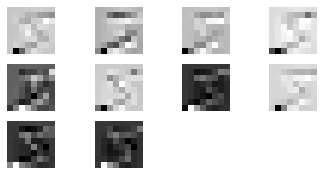

In [21]:
show_layer_output(cnnet, Xtrain, 0);

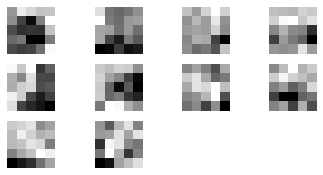

In [22]:
show_layer_weights(cnnet, 0);

### Discussion

The output of the convolutional looks like its either capturing straight lines (the top of the 5 or the bottom of the 5) or curved lines (the rightside/bottom curve of the 5). The layer weights seemed to be focused on the bottom area (the line on the bottom of the five), the right middle area (the rightside/bottom curve of the 5), or the top area (the line on the top of the five). It looks like the layer weights focus on one or two areas in the picture and if a line appears in that area it is accentuated in the output images of the convalutional layer.

## Extra Credit 2

In [23]:
cnnet_non_gpu = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[10, 20, 30, 40],
                                   n_units_in_fc_hidden_layers=[10], 
                                   classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                   kernels_size_and_stride=[[5, 3], [4, 2], [3, 2], [1, 2]],
                                   use_gpu=False)
cnnet_non_gpu.train(Xtrain, Ttrain, 200, learning_rate=0.01)
cnnet_non_gpu.training_time

Epoch 20 error 0.87895
Epoch 40 error 0.33125
Epoch 60 error 0.15939
Epoch 80 error 0.09495
Epoch 100 error 0.06356
Epoch 120 error 0.04603
Epoch 140 error 0.03497
Epoch 160 error 0.02775
Epoch 180 error 0.02297
Epoch 200 error 0.01948


208.53940796852112

In [24]:
cnnet_gpu = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[10, 20, 30, 40],
                                   n_units_in_fc_hidden_layers=[10], 
                                   classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                   kernels_size_and_stride=[[5, 3], [4, 2], [3, 2], [1, 2]],
                                   use_gpu=True)
cnnet_gpu.train(Xtrain, Ttrain, 200, learning_rate=0.01)
cnnet_gpu.training_time

Epoch 20 error 0.92195
Epoch 40 error 0.35166
Epoch 60 error 0.16741
Epoch 80 error 0.10402
Epoch 100 error 0.07130
Epoch 120 error 0.05246
Epoch 140 error 0.04040
Epoch 160 error 0.03226
Epoch 180 error 0.02632
Epoch 200 error 0.02180


26.813615560531616

### Discussion

Without the gpu the time was ~208 seconds and with the gpu it was ~26 seconds. Running a convalutional layers seems really computationally expensive especially when the kernel size and stride are small. This is likely because the CNN has to look at more sub-areas of the picture which requires alot of matrix calculations. So running matrix calculations on a gpu really speeds up the training of a CNN.

In [25]:
# !rm A4grader.zip
# !rm A4grader.py
# !wget https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.zip
# !unzip A4grader.zip
# %run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Armstrong-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing if your NeuralNetwork_Convolutional can learn to classify a small 
subset of hand_drawn 0, 1, and 2 digits.

import numpy as np
import pickle, gzip

# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
Xtest = test_set[0]
traini = [3,  10,  13,  25,  28,  55,  69,  71, 101, 126, 2,   5,  14,  29,  31,  37,  39,  40,  46,  57, 1,  35,  38,  43,  47,  72,  77,  82, 106, 119]
testi = [136, 148, 157, 183, 188, 192, 194, 215, 246, 269,  74,  89,  94, 96, 107, 135, 137, 143, 145, 154, 147, 149, 172, 174, 186, 199, 208, 221, 222, 225]
Xtrain = test_set[0][traini, :].reshape(-1, 1, 28, 28)
Ttrain = test_set[1][traini].reshape(-1, 1)
Xtest = test_set[0][testi, :].reshap